In [1]:
from z3 import *

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from IPython.display import Image

from av_goal_recognition.goal_recognition import HandcraftedGoalTrees, TrainedDecisionTrees
from av_goal_recognition.verification import add_goal_tree_model
from av_goal_recognition.data_processing import get_dataset
from av_goal_recognition.feature_extraction import FeatureExtractor
from av_goal_recognition.scenario import ScenarioConfig, Scenario
from av_goal_recognition.base import get_data_dir, get_scenario_config_dir, get_img_dir
from av_goal_recognition.lanelet_helpers import LaneletHelpers

## Handcrafted goal tree

In [2]:
scenario_name = 'heckstrasse'
model = HandcraftedGoalTrees.load(scenario_name)
reachable_goals = [(1, 'straight-on'), (2, 'turn-left')]

s = Solver()

features, probs = add_goal_tree_model(reachable_goals, s, model)

# unsatisfiable if G2 always has highest prob
verify_expr = Implies(And(features[1]['in_correct_lane'], Not(features[2]['in_correct_lane'])), probs[2] < probs[1])
s.add(Not(verify_expr))

print(s.check())


Errors ocurred while parsing Lanelet Map:
	- Error parsing primitive -1770767: Lanelet has not exactly one left border!
	- Error parsing primitive -1770767: Lanelet has not exactly one right border!
	- Error parsing primitive -1770766: Lanelet has not exactly one left border!
	- Error parsing primitive -1770787: Could not complete boundary around linestring -1770573
	- Error parsing primitive -1770787: Could not complete boundary around linestring -1770492
	- Error parsing primitive -1770787: Areas must have exactly one outer ring!
unsat


verified true:
If car is in correct lane for G1, then G1 is predicted

In [3]:
scenario_name = 'heckstrasse'
model = HandcraftedGoalTrees.load(scenario_name)
reachable_goals = [(1, 'straight-on'), (2, 'turn-left')]

s = Solver()

features, probs = add_goal_tree_model(reachable_goals, s, model)

verify_expr = Implies(And(Not(features[1]['in_correct_lane']),
                          features[2]['in_correct_lane']), probs[2] > probs[1])
s.add(Not(verify_expr))

print(s.check())

Errors ocurred while parsing Lanelet Map:
	- Error parsing primitive -1770767: Lanelet has not exactly one left border!
	- Error parsing primitive -1770767: Lanelet has not exactly one right border!
	- Error parsing primitive -1770766: Lanelet has not exactly one left border!
	- Error parsing primitive -1770787: Could not complete boundary around linestring -1770573
	- Error parsing primitive -1770787: Could not complete boundary around linestring -1770492
	- Error parsing primitive -1770787: Areas must have exactly one outer ring!
unsat


Verified true:
If car is in correct lane for G2, G2 is predicted


# Trained goal tree

In [4]:
scenario_name = 'heckstrasse'
model = TrainedDecisionTrees.load(scenario_name)
reachable_goals = [(1, 'straight-on'), (2, 'turn-left')]

s = Solver()

features, probs = add_goal_tree_model(reachable_goals, s, model)

verify_expr = Implies(And(features[1]['in_correct_lane'],
                          Not(features[2]['in_correct_lane'])),
                      probs[2] < probs[1])
s.add(Not(verify_expr))

print(s.check())

Errors ocurred while parsing Lanelet Map:
	- Error parsing primitive -1770767: Lanelet has not exactly one left border!
	- Error parsing primitive -1770767: Lanelet has not exactly one right border!
	- Error parsing primitive -1770766: Lanelet has not exactly one left border!
	- Error parsing primitive -1770787: Could not complete boundary around linestring -1770573
	- Error parsing primitive -1770787: Could not complete boundary around linestring -1770492
	- Error parsing primitive -1770787: Areas must have exactly one outer ring!
sat


In [5]:
s.model()

[in_correct_lane_2 = False,
 2_turn-left = 37205845925191977/100000000000000000,
 path_to_goal_length_2 = 611815071105957/10000000000000,
 vehicle_in_front_speed_1 = 7422869920730591/500000000000000,
 acceleration_2 = 183992999792099/200000000000000,
 acceleration_1 = 0,
 path_to_goal_length_1 = 783497200012207/10000000000000,
 angle_in_lane_2 = 2049232483841479/1000000000000000000,
 1_straight-on = 3328868578632209/62500000000000000,
 in_correct_lane_1 = True,
 angle_in_lane_1 = 1259317109361291/25000000000000000]

Verification failed: If car is in correct lane for G1, then G1 is predicted.
Angle in lane > 0.08

## Investigate examples of this

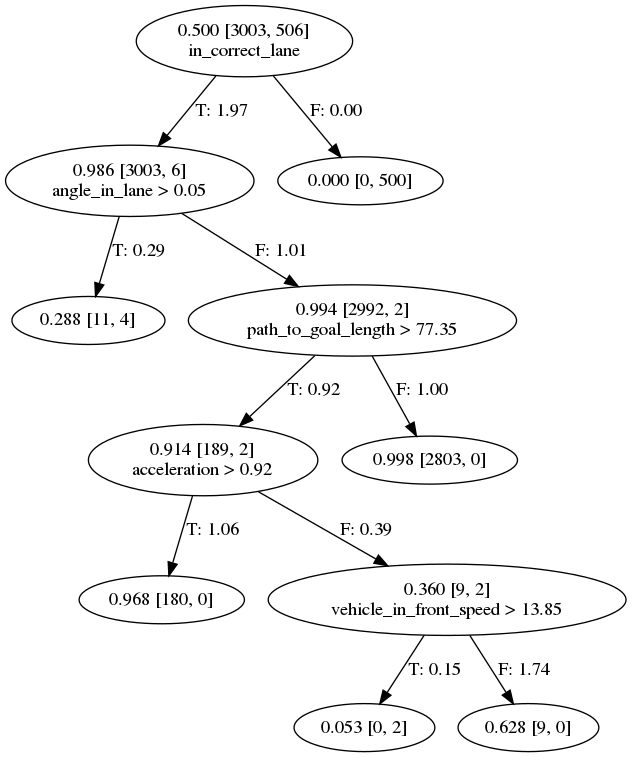

In [6]:
Image("../images/trained_tree_heckstrasse_G1_straight-on.png")

In [7]:
dataset = get_dataset(scenario_name, 'train')

Errors ocurred while parsing Lanelet Map:
	- Error parsing primitive -1770767: Lanelet has not exactly one left border!
	- Error parsing primitive -1770767: Lanelet has not exactly one right border!
	- Error parsing primitive -1770766: Lanelet has not exactly one left border!
	- Error parsing primitive -1770787: Could not complete boundary around linestring -1770573
	- Error parsing primitive -1770787: Could not complete boundary around linestring -1770492
	- Error parsing primitive -1770787: Areas must have exactly one outer ring!


In [8]:
scenario = Scenario.load(get_scenario_config_dir() + '{}.json'.format(scenario_name))

Errors ocurred while parsing Lanelet Map:
	- Error parsing primitive -1770767: Lanelet has not exactly one left border!
	- Error parsing primitive -1770767: Lanelet has not exactly one right border!
	- Error parsing primitive -1770766: Lanelet has not exactly one left border!
	- Error parsing primitive -1770787: Could not complete boundary around linestring -1770573
	- Error parsing primitive -1770787: Could not complete boundary around linestring -1770492
	- Error parsing primitive -1770787: Areas must have exactly one outer ring!


In [9]:
feature_extractor = FeatureExtractor(scenario.lanelet_map)

In [10]:
episode = scenario.load_episode(0)

In [11]:
state = episode.frames[8292].agents[114]

In [12]:
goal_routes = feature_extractor.get_goal_routes(state, scenario.config.goals)

ID -1770527: Linestring type must be specified
Found the following unknown types, did not plot them: ['wall', 'arrow']


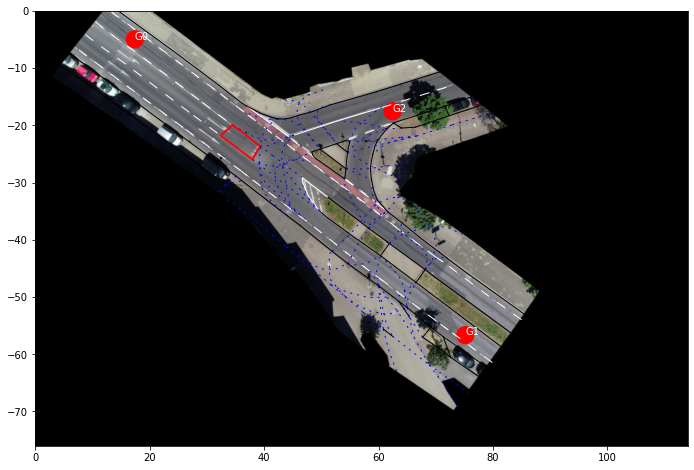

In [13]:
plt.figure(figsize=(12,8))
scenario.plot()
LaneletHelpers.plot(goal_routes[1].shortestPath()[0])

ID -1770527: Linestring type must be specified
Found the following unknown types, did not plot them: ['wall', 'arrow']


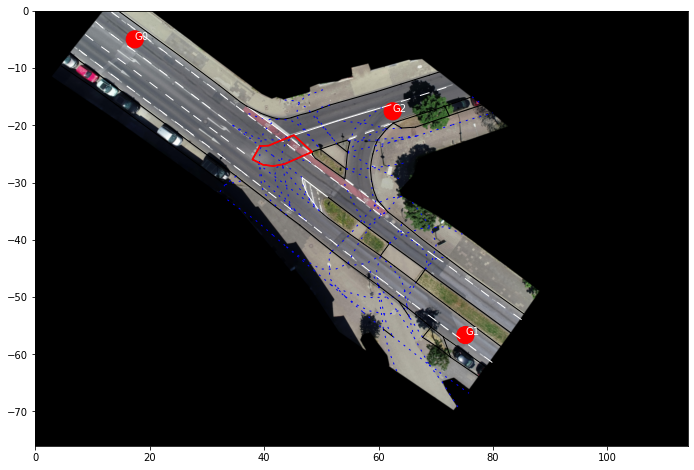

In [14]:
plt.figure(figsize=(12,8))
scenario.plot()
LaneletHelpers.plot(goal_routes[2].shortestPath()[0])

In [15]:
dataset.loc[(dataset.in_correct_lane)  
            & (dataset.angle_in_lane > 0.08)
           & (dataset.possible_goal==1) & (dataset.goal_type=='straight-on')]

,path_to_goal_length,in_correct_lane,speed,acceleration,angle_in_lane,vehicle_in_front_dist,vehicle_in_front_speed,oncoming_vehicle_dist,goal_type,agent_id,possible_goal,true_goal,true_goal_type,frame_id,initial_frame_id,fraction_observed,episode
670,80.783259,True,10.63672,0.67458,0.086457,56.824550,14.20752,100.0,straight-on,40,1,2,turn-left,3034,3034,0.0,0
672,73.372438,True,10.66683,-1.15167,0.098684,59.024640,14.01456,100.0,straight-on,40,1,2,turn-left,3051,3034,0.1,0
5632,45.574786,True,3.95654,1.10213,0.536447,24.257528,8.99368,100.0,straight-on,275,1,2,turn-left,14329,13669,1.0,2


Reasons for wrong lane:
1. Start of trajectory, has not yet changed lane

heckstrasse agent 114 frame 8292 get current lanelet?


In [16]:
scenario_name = 'heckstrasse'
model = TrainedDecisionTrees.load(scenario_name)
reachable_goals = [(1, 'straight-on'), (2, 'turn-left')]

s = Solver()

features, probs = add_goal_tree_model(reachable_goals, s, model)


verify_expr = Implies(And(Not(features[1]['in_correct_lane']), features[2]['in_correct_lane']), probs[2] > probs[1])
s.add(Not(verify_expr))

print(s.check())

Errors ocurred while parsing Lanelet Map:
	- Error parsing primitive -1770767: Lanelet has not exactly one left border!
	- Error parsing primitive -1770767: Lanelet has not exactly one right border!
	- Error parsing primitive -1770766: Lanelet has not exactly one left border!
	- Error parsing primitive -1770787: Could not complete boundary around linestring -1770573
	- Error parsing primitive -1770787: Could not complete boundary around linestring -1770492
	- Error parsing primitive -1770787: Areas must have exactly one outer ring!
unsat


Verified true: If car is in correct lane for G2, G2 is predicted